<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Polynomial-Regression" data-toc-modified-id="Polynomial-Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Polynomial Regression</a></span><ul class="toc-item"><li><span><a href="#Learning-curve" data-toc-modified-id="Learning-curve-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Learning curve</a></span></li><li><span><a href="#Regularised-Linear-Model" data-toc-modified-id="Regularised-Linear-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Regularised Linear Model</a></span><ul class="toc-item"><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Ridge Regression</a></span></li><li><span><a href="#Lasso-Regression" data-toc-modified-id="Lasso-Regression-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Lasso Regression</a></span></li><li><span><a href="#Elastic-Net" data-toc-modified-id="Elastic-Net-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Elastic Net</a></span></li><li><span><a href="#Early-stopping" data-toc-modified-id="Early-stopping-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Early stopping</a></span></li></ul></li></ul></li></ul></div>

# Polynomial Regression

In [56]:
import numpy as np
m = 100
X = 6*np.random.rand(m,1)-3
y=0.5*X**2 + X + 2+np.random.randn(m,1)

In [57]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias = False)
X_poly = poly_features.fit_transform(X)
print("X[0]: ",X[0])
print("X_poly[0]", X_poly[0])

X[0]:  [1.29515988]
X_poly[0] [1.29515988 1.67743912]


In [58]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.92844284]), array([[1.13519607, 0.53374   ]]))

* The original function was $y= 0.5x^2 + 1.0x + 2+ Gaussian noise$
* prediction shows $y=0.49x^2 + 1.12x + 2.04$

In [59]:
#绘制回归曲线
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

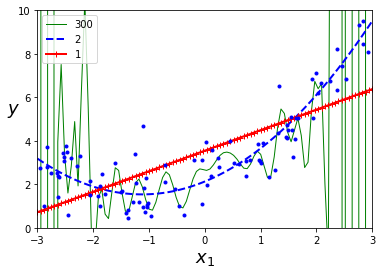

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline((
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ))
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

## Learning curve

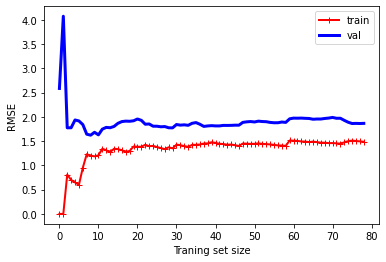

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)
    train_errors, val_errors=[],[]
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.xlabel("Traning set size")
    plt.ylabel("RMSE")
    
lin_reg = LinearRegression()

plot_learning_curves(lin_reg, X, y)

Training:
* when there are just 1-2 training set, RMSE 0
* As new instances added, it is impossible for the model to fit the training data perfectly
* error goes up until it reaches a plateau (addining more instances to the training set doesn't make the average error better or worse)

Val:
* it is incapable of generalising in the begining, so the validatin error is initially quite big
* it goes down, and because this is 'linear regression', the stragiht line can not do a good job modeling the data, so the error ends up at a plateau

-> typical underfitting.
-> Both curves have reached a plateau; they are close and faily high

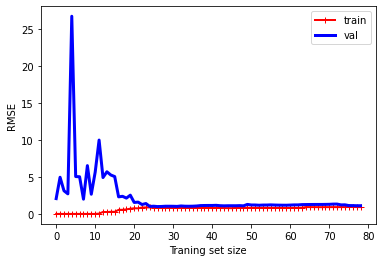

In [39]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

* The errors are much lower than on ein linear regression
* looks like it fitted well - no gap between train /val (expected overfitting but not overfitting?)

## Regularised Linear Model
* polynomial model : reduce the number of polynomial degrees.
* linear model: constrain the weights of the model

### Ridge Regression
* Tikhonov reglarisation
* cost function : 
$J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}\theta_{i}^2$

In [43]:
# using closed-form solution
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[4.96103135]])

In [46]:
# using StochasticGradient Descent
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([4.92341272])

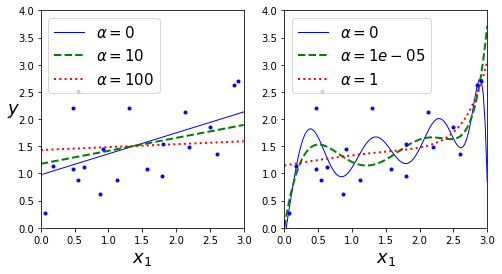

In [60]:

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline((
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ))
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

* left: plain Ridge models are used, leading to linear prediction
* right: polynomial regression with ridge regularisation
* increasing $\alpha$ -> flatter(less extreme, more reasonable) predictions, thus reducing the model's variance but increasing its bias

### Lasso Regression
* Least Absolute Shrinkage and Selection Operator Regression
* cost function : 
$J(\theta) = MSE(\theta) + \alpha\sum_{i=1}^{n}|\theta_{i}|$
* tend to eliminate the weights of the least important features(set them to 0)

In [48]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.90924941])

In [49]:
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([4.94168058])

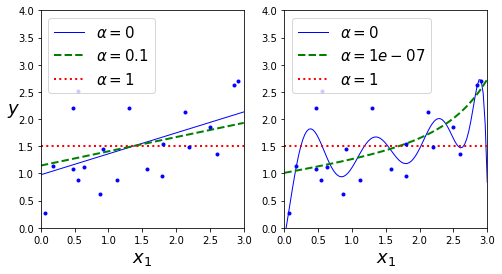

In [61]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

* the dashed line in the right plot($\alpha = 10^{-7}$) looks quadratic, almost linear: all the weights for the high-degree polynoial features are equal to zero.
* Lasso Regression automatically performs feature selection and outputs a sparse model(with few nonzero feature weights)

### Elastic Net
* a middle ground betwwen Ridge and Lasso
* cost function : 
$J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^{n}|\theta_{i}| + \frac{1-r}{2}\alpha\sum_{i=1}^{n}\theta_{i}^2$

In [50]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio = 0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.91175874])

### Early stopping
* stop training as soon as the validation error reaches a minimum
* Geoffrey Hinton called it a "beautiful free lunch."

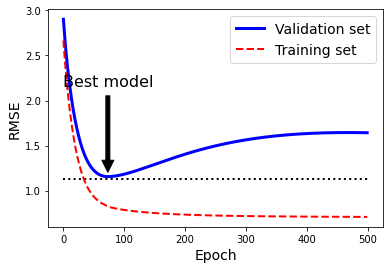

In [65]:
# Early Stopping -- stop training when minimum validation error reached

# build dataset
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

poly_scaler = Pipeline((
    ("poly_features", PolynomialFeatures(
        degree=90, 
        include_bias=False)),
    ("std_scaler", StandardScaler()),
    ))

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled   = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(n_iter_no_change=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)

    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict   = sgd_reg.predict(X_val_poly_scaled)

    train_errors.append(mean_squared_error(y_train_predict, y_train))
    val_errors.append(mean_squared_error(y_val_predict, y_val))

best_epoch    = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
#save_fig("early_stopping_plot")
plt.show()

*reference: Hands-on Machine Leraning with Scikit-Learn, Keras & Tensorflow by Aurélien Géron*